# NBA-22: Resultats des Modeles ML

Analyse des performances des modeles Random Forest et Gradient Boosting pour la prediction des matchs NBA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Chargement des Donnees

In [2]:
# Charger les features
df = pd.read_parquet("../data/gold/ml_features/features_all.parquet")

print(f"Dataset: {len(df)} matchs")
print(f"Saisons: {sorted(df['season'].unique())}")
print(f"Features: {len(df.columns)} colonnes")
print(f"\nDistribution target:")
print(df['target'].value_counts(normalize=True))

Dataset: 8871 matchs
Saisons: ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
Features: 55 colonnes

Distribution target:
target
1    0.557998
0    0.442002
Name: proportion, dtype: float64


## 2. Chargement des Resultats

In [3]:
# Trouver la derniere experimentation
exp_dir = sorted(Path("../models/experiments").glob("nba22_*"))[-1]
metrics_file = exp_dir / "metrics.json"

with open(metrics_file) as f:
    results = json.load(f)

print(f"Experimentation: {exp_dir.name}")
print(f"Timestamp: {results['timestamp']}")
print(f"Train size: {results['train_size']}")
print(f"Test size: {results['test_size']}")
print(f"N features: {results['n_features']}")

Experimentation: nba22_20260208_111840
Timestamp: 20260208_111840
Train size: 6250
Test size: 2621
N features: 24


## 3. Comparaison des Modeles

In [4]:
# Creer DataFrame de comparaison
comparison_data = []
for model_name, metrics in results['models'].items():
    comparison_data.append({
        'Modele': metrics['model_name'],
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'AUC': metrics['auc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Modele')

display(comparison_df.style.background_gradient(cmap='YlGn', axis=0).format('{:.3f}'))

,Accuracy,Precision,Recall,F1-Score,AUC
Modele,,,,,
Random Forest,0.761,0.755,0.831,0.791,0.839
Gradient Boosting,0.756,0.758,0.813,0.784,0.832


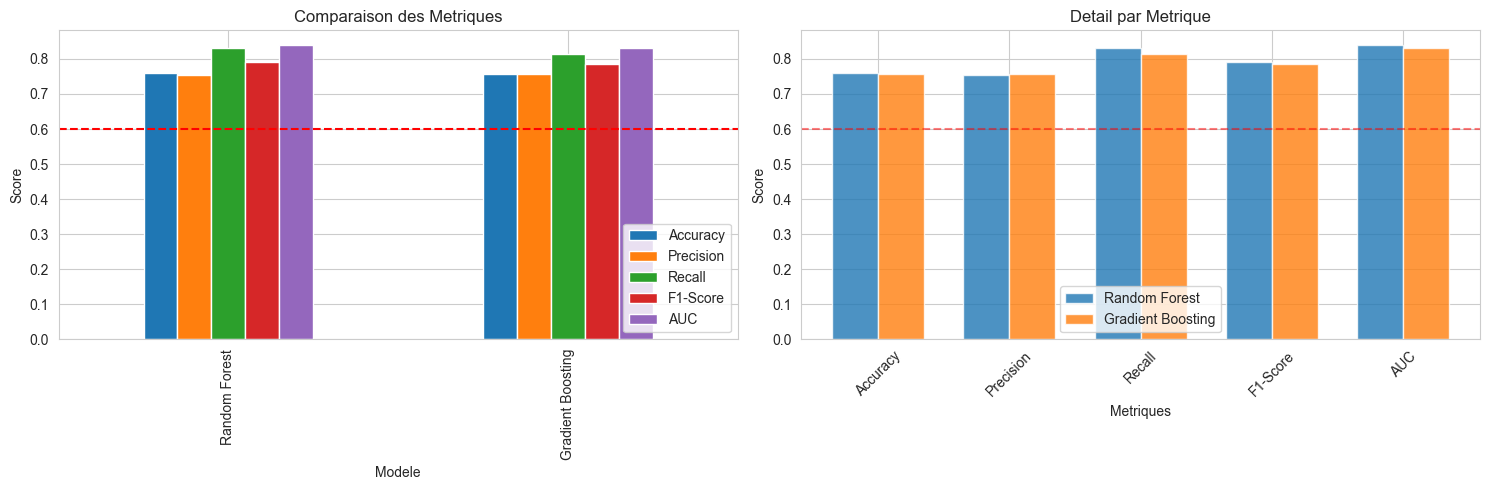

In [5]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Barplot des metriques
comparison_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Comparaison des Metriques')
axes[0].set_ylabel('Score')
axes[0].legend(loc='lower right')
axes[0].axhline(y=0.60, color='r', linestyle='--', label='Objectif (60%)')

# Radar chart simplifie
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics_cols))
width = 0.35

rf_values = comparison_df.loc['Random Forest', metrics_cols].values
gbt_values = comparison_df.loc['Gradient Boosting', metrics_cols].values

axes[1].bar(x - width/2, rf_values, width, label='Random Forest', alpha=0.8)
axes[1].bar(x + width/2, gbt_values, width, label='Gradient Boosting', alpha=0.8)
axes[1].set_xlabel('Metriques')
axes[1].set_ylabel('Score')
axes[1].set_title('Detail par Metrique')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_cols, rotation=45)
axes[1].legend()
axes[1].axhline(y=0.60, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 4. Feature Importance

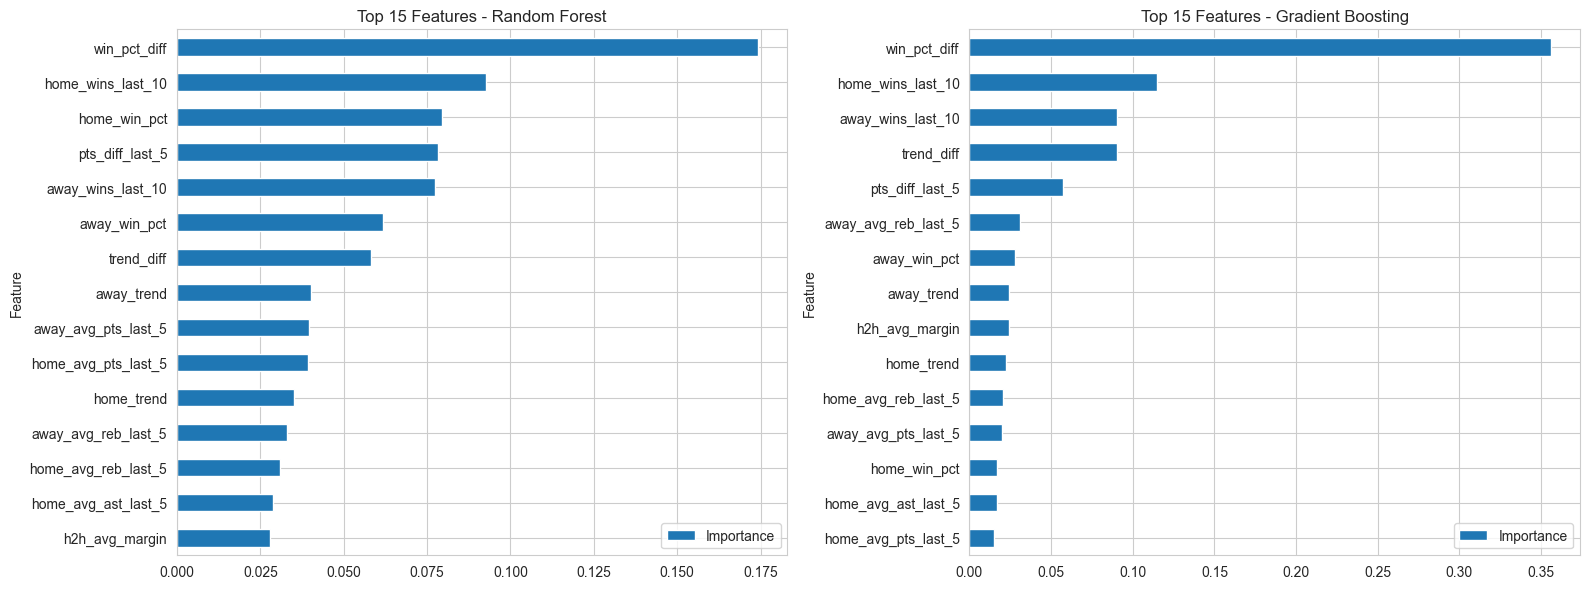

In [6]:
# Top 15 features pour chaque modele
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (model_name, metrics) in enumerate(results['models'].items()):
    importance = metrics['feature_importance']
    top_features = dict(list(importance.items())[:15])
    
    df_imp = pd.DataFrame(
        list(top_features.items()),
        columns=['Feature', 'Importance']
    )
    
    df_imp.plot(x='Feature', y='Importance', kind='barh', ax=axes[idx])
    axes[idx].set_title(f"Top 15 Features - {metrics['model_name']}")
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

In [7]:
# Comparer feature importance entre modeles
rf_imp = results['models']['rf']['feature_importance']
gbt_imp = results['models']['gbt']['feature_importance']

# Top 10 features communes
top_rf = set(list(rf_imp.keys())[:10])
top_gbt = set(list(gbt_imp.keys())[:10])
common = top_rf.intersection(top_gbt)

print(f"\nTop 10 RF: {len(top_rf)} features")
print(f"Top 10 GBT: {len(top_gbt)} features")
print(f"Communes: {len(common)} features")
print(f"\nFeatures communes:")
for f in common:
    print(f"  - {f}")


Top 10 RF: 10 features
Top 10 GBT: 10 features
Communes: 7 features

Features communes:
  - home_wins_last_10
  - pts_diff_last_5
  - away_wins_last_10
  - trend_diff
  - away_win_pct
  - away_trend
  - win_pct_diff


## 5. Analyse des Predictions

In [8]:
# Charger le meilleur modele
import joblib

best_model_name = results['best_model']['name']
model_path = exp_dir / f"model_{best_model_name}.joblib"
model = joblib.load(model_path)

print(f"Meilleur modele: {best_model_name.upper()}")
print(f"Accuracy: {results['best_model']['accuracy']:.3f}")

Meilleur modele: RF
Accuracy: 0.761


Features utilisees: 24


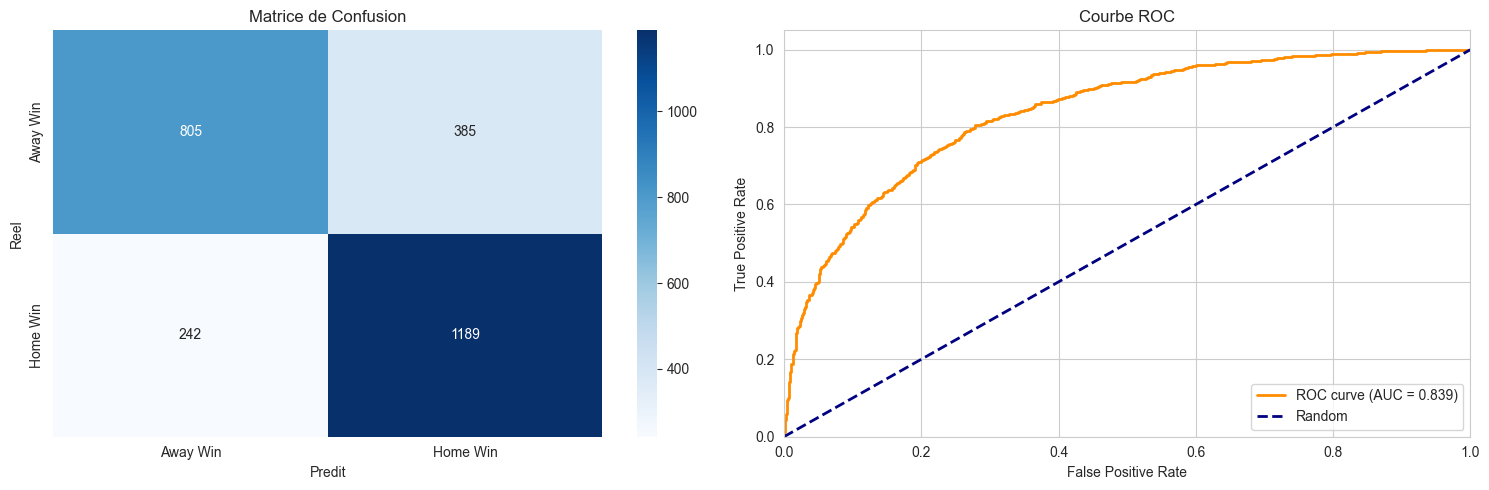

In [9]:
# Preparer donnees test
test_mask = df['season'].isin(['2023-24', '2024-25'])

# UTILISER EXACTEMENT LES MEMES FEATURES QUE PENDANT L'ENTRAINEMENT
# (sans data leakage - pas de scores/stats du match en cours)
exclude_cols = [
    'game_id', 'season', 'game_date', 'season_type',
    'home_team_id', 'home_team_name', 'home_team_abbr',
    'away_team_id', 'away_team_name', 'away_team_abbr',
    'home_wl', 'away_wl', 'target',
    'point_diff', 'home_score', 'away_score',
    'home_reb', 'home_ast', 'home_stl', 'home_blk', 'home_tov', 'home_pf',
    'away_reb', 'away_ast', 'away_stl', 'away_blk', 'away_tov', 'away_pf',
    'home_ts_pct', 'home_efg_pct', 'home_game_score', 'home_fatigue_eff',
    'away_ts_pct', 'away_efg_pct', 'away_game_score', 'away_fatigue_eff',
    'ts_pct_diff'
]

feature_cols = [c for c in df.columns if c not in exclude_cols]
print(f"Features utilisees: {len(feature_cols)}")

X_test = df.loc[test_mask, feature_cols]
y_test = df.loc[test_mask, 'target']

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'])
axes[0].set_title('Matrice de Confusion')
axes[0].set_ylabel('Reel')
axes[0].set_xlabel('Predit')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Courbe ROC')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## 6. Analyse par Saison

,Saison,Matchs,Accuracy,Home Win %
0,2023-24,1312,0.753049,0.545732
1,2024-25,1309,0.768526,0.546218


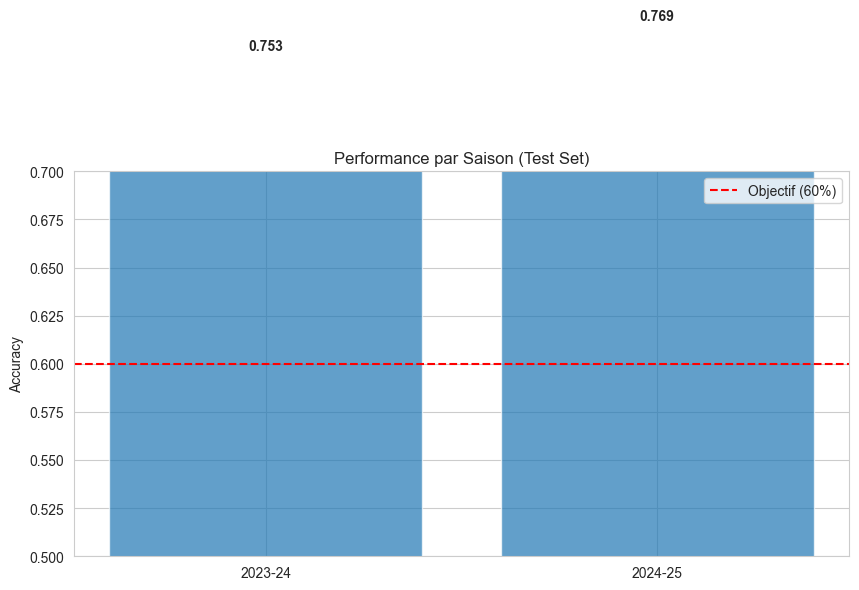

In [10]:
# Performance par saison (test set)
from sklearn.metrics import accuracy_score

season_results = []
for season in ['2023-24', '2024-25']:
    season_mask = (df['season'] == season) & test_mask
    if season_mask.sum() > 0:
        X_season = df.loc[season_mask, feature_cols]
        y_season = df.loc[season_mask, 'target']
        y_pred_season = model.predict(X_season)
        
        acc = accuracy_score(y_season, y_pred_season)
        season_results.append({
            'Saison': season,
            'Matchs': len(y_season),
            'Accuracy': acc,
            'Home Win %': y_season.mean()
        })

season_df = pd.DataFrame(season_results)
display(season_df)

# Visualisation
plt.figure(figsize=(10, 5))
plt.bar(season_df['Saison'], season_df['Accuracy'], alpha=0.7)
plt.axhline(y=0.60, color='r', linestyle='--', label='Objectif (60%)')
plt.ylabel('Accuracy')
plt.title('Performance par Saison (Test Set)')
plt.legend()
plt.ylim(0.5, 0.7)
for i, row in season_df.iterrows():
    plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.3f}", 
             ha='center', fontweight='bold')
plt.show()

## 7. Analyse des Erreurs

In [11]:
# Analyse des erreurs
errors = df.loc[test_mask].copy()
errors['prediction'] = y_pred
errors['probability'] = y_proba
errors['error'] = errors['target'] != errors['prediction']

print(f"Total erreurs: {errors['error'].sum()} / {len(errors)} ({errors['error'].mean():.1%})")

# Erreurs par type
print("\nErreurs par type:")
print(f"  False Positives (pred home, reel away): {((errors['prediction']==1) & (errors['target']==0)).sum()}")
print(f"  False Negatives (pred away, reel home): {((errors['prediction']==0) & (errors['target']==1)).sum()}")

Total erreurs: 627 / 2621 (23.9%)

Erreurs par type:
  False Positives (pred home, reel away): 385
  False Negatives (pred away, reel home): 242


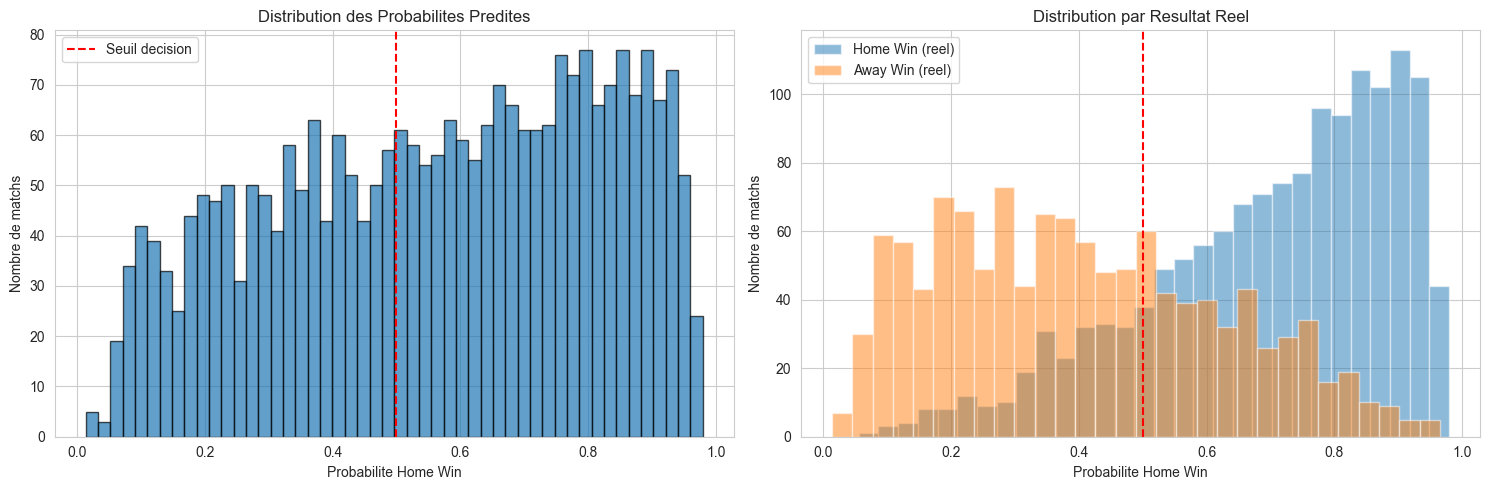

In [12]:
# Distribution des probabilites
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Toutes les predictions
axes[0].hist(errors['probability'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Probabilite Home Win')
axes[0].set_ylabel('Nombre de matchs')
axes[0].set_title('Distribution des Probabilites Predites')
axes[0].axvline(x=0.5, color='r', linestyle='--', label='Seuil decision')
axes[0].legend()

# Par resultat reel
errors[errors['target']==1]['probability'].hist(bins=30, alpha=0.5, label='Home Win (reel)', ax=axes[1])
errors[errors['target']==0]['probability'].hist(bins=30, alpha=0.5, label='Away Win (reel)', ax=axes[1])
axes[1].set_xlabel('Probabilite Home Win')
axes[1].set_ylabel('Nombre de matchs')
axes[1].set_title('Distribution par Resultat Reel')
axes[1].axvline(x=0.5, color='r', linestyle='--')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Resume et Conclusion

In [13]:
# Resume final
print("="*70)
print("RESUME NBA-22")
print("="*70)
print(f"\nExperimentation: {exp_dir.name}")
print(f"Modeles testes: Random Forest, Gradient Boosting")
print(f"\nMeilleur modele: {results['best_model']['name'].upper()}")
print(f"   Accuracy: {results['best_model']['accuracy']:.3f}")

if results['best_model']['accuracy'] > 0.60:
    print("   Objectif atteint (> 60%)")
else:
    print("   Objectif non atteint (< 60%)")

print("\nTop 5 features importantes:")
best_model_key = results['best_model']['name']
top5 = list(results['models'][best_model_key]['feature_importance'].keys())[:5]
for i, feat in enumerate(top5, 1):
    print(f"  {i}. {feat}")

print("\n="*70)

RESUME NBA-22

Experimentation: nba22_20260208_111840
Modeles testes: Random Forest, Gradient Boosting

Meilleur modele: RF
   Accuracy: 0.761
   Objectif atteint (> 60%)

Top 5 features importantes:
  1. win_pct_diff
  2. home_wins_last_10
  3. home_win_pct
  4. pts_diff_last_5
  5. away_wins_last_10

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=


## Prochaines Etapes

- [ ] **NBA-22-2**: Regression pour predire le score exact
- [ ] **NBA-22-3**: Clustering des profils de joueurs
- [ ] **NBA-23**: Detection des joueurs en progression
- [ ] **NBA-24**: Detection des joueurs en progression
- [ ] **NBA-25**: Pipeline ML automatise